In [1]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from catboost import CatBoostClassifier, Pool
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
import os,sys

modelNames = ['ZScorePredictor','FiveDayPredictor','TmmrwUpPredictor']
verbose = False
secretColumns = ['zScoreOfChangeTmmrw','percentChangeInFiveDays', 'sector', 'tmmrwChngAsPerc']
sectorFolder = 'data/by_sector'
catLabels = ['ticker','industry']
trainDir = 'trainData/'

In [2]:
def scoreCalculator(predictor, attributes, labels):
    predicted = predictor.predict(attributes)
    errorScore = 0
    for guessIndex in range(len(predicted)):
        guess = predicted[guessIndex]
        actual = labels[guessIndex]
        if guess == 'hold' :
            errorScore += 0
        elif guess == 'long':
            if actual == 'short':
                errorScore += -15
            elif actual == 'hold':
                errorScore += -5
            else :#actual == 'long'
                errorScore += 20
        else: #short
            if actual == 'long':
                errorScore += -20
            elif actual == 'hold':
                errorScore += 0
            else: #actual == short
                errorScore += 20
    if verbose:
        myMatrix = plot_confusion_matrix(predictor, attributes, labels,
                                     cmap=plt.cm.Blues, normalize = 'all')    
        plt.show()
    return  errorScore/len(predicted)

In [3]:
def catBoostMaker(df,zScoreAnswer,fiveDayChangeAnswer, tmmrwUpAnswer, count, toSave, sector):
    catIndicies = []
    counter = -1
    for col in df.columns: #finding indices for cat variables
        counter += 1
        if col in catLabels:
            catIndicies.append(counter)
    masterList = df.values
    masterTrainList, masterTestList, zScoreTrainList, zScoreTestList, fiveDayChangeTrainList, fiveDayChangeTestList, tmmrwUpTrainList, tmmrwUpTestList = \
    train_test_split(masterList, zScoreAnswer, fiveDayChangeAnswer, tmmrwUpAnswer, test_size = .25)
    
    answerTrainList = [zScoreTrainList,fiveDayChangeTrainList, tmmrwUpTrainList]
    answerTestList = [zScoreTestList,fiveDayChangeTestList, tmmrwUpTestList]
    trainPools = [Pool(data = masterTrainList, label = x, cat_features = catIndicies) for x in answerTrainList]
    testPools = [Pool(data = masterTestList, label = x, cat_features = catIndicies) for x in answerTestList]
    
    folderRoot = 'catPredictors/'
    accuracyList = []
    scoreList = []
    featureDF = pd.DataFrame(data = 
                         {'featureName': [col for col in df.columns],
                        'importance': [0] * len([col for col in df.columns])}).set_index('featureName')
    for name, train, test in zip(modelNames, trainPools, testPools):
        train.set_feature_names([x for x in df.columns])
        model = CatBoostClassifier(bootstrap_type = 'Bernoulli', iterations = 150, 
                                   train_dir = '{}{}_{}'.format(trainDir, sector, count))
        model.fit(train, eval_set = test, logging_level = 'Silent')
        if toSave:
            sectorFolder = '{}{}'.format(folderRoot, sector)
            if not os.path.exists(sectorFolder):
                os.makedirs(sectorFolder)
            model.save_model('{}/{}-{}.cbm'.format(sectorFolder, name, count))
        accuracy =  model.score(test)
        error = scoreCalculator(model, test,test.get_label())
        accuracyList.append(accuracy)
        scoreList.append(error)
        featureList = CatBoostClassifier.get_feature_importance(model, prettified = True)
        featureDFPart = pd.DataFrame(data = 
                     {'featureName': featureList['Feature Id'],
                    'importance': featureList['Importances']}).set_index('featureName')
        featureDF = featureDF + featureDFPart
        if verbose:
            print(name)
            print('Accuracy: ', accuracy)
            print('Error Score:', error)
        
    averageAccuracy = sum([x for x in accuracyList])/len(accuracyList)
    averageScore = sum([x for x in scoreList])/len(scoreList)
    featureList = CatBoostClassifier.get_feature_importance(model, prettified = True)
    return averageAccuracy, averageScore, featureDF

In [4]:
#returns feature to remove, mean error score, # of significant (non answer or date) columns
def buildForest(file, droppedColumns, toSave):
    sector = file.split('.')[0]
    sector = sector.replace(' ', '-')
    file = sectorFolder + '/' + file
    secretColumns = ['zScoreOfChangeTmmrw','percentChangeInFiveDays', 'sector', 'tmmrwChngAsPerc']
    catAccuracy = []
    catError = []
    masterFeatureDF = None
    colCount = 0
    combinedDF = None
    if os.stat(file).st_size > 2000000:
        chunks = pd.read_csv(file, parse_dates = True, chunksize = 150000)
        for idx, chunk in enumerate(chunks):
            chunk.drop(columns = ['Date'], inplace = True)
            zScoreAnswer = chunk['zScoreOfChangeTmmrw']
            zScoreAnswer = zScoreAnswer.astype('float')
            zScoreAnswer = ['long' if x > .1 else 'short' if x < -.1 else 'hold' for x in zScoreAnswer ]
            fiveDayChangeAnswer = chunk['percentChangeInFiveDays']
            fiveDayChangeAnswer = ['long' if x > .005 else 'short' if x < -.005 else 'hold' for x in fiveDayChangeAnswer]
            tmmrwUpAnswer = chunk['tmmrwChngAsPerc']
            tmmrwUpAnswer = ['long' if x > 0 else 'short' for x in tmmrwUpAnswer]

            chunk.drop(columns = secretColumns, inplace = True)
            accuracy, error, featureDF = \
            catBoostMaker(chunk,zScoreAnswer,fiveDayChangeAnswer, tmmrwUpAnswer, idx, toSave, sector)
            catAccuracy.append(accuracy)
            catError.append(error)
            if idx == 0:
                masterFeatureDF = featureDF
            else:
                masterFeatureDF = masterFeatureDF + featureDF
            break


    else :
        combinedDF = pd.read_csv(file, parse_dates = True)
        combinedDF.drop(columns = ['Date'], inplace = True)
        zScoreAnswer = combinedDF['zScoreOfChangeTmmrw']
        zScoreAnswer = zScoreAnswer.astype('float')
        zScoreAnswer = ['long' if x > .1 else 'short' if x < -.1 else 'hold' for x in zScoreAnswer ]
        fiveDayChangeAnswer = combinedDF['percentChangeInFiveDays']
        fiveDayChangeAnswer = ['long' if x > .005 else 'short' if x < -.005 else 'hold' for x in fiveDayChangeAnswer]
        tmmrwUpAnswer = combinedDF['tmmrwChngAsPerc']
        tmmrwUpAnswer = ['long' if x > 0 else 'short' for x in tmmrwUpAnswer]

        combinedDF.drop(columns = secretColumns, inplace = True)
        accuracy, error, featureDF = \
        catBoostMaker(chunk,zScoreAnswer,fiveDayChangeAnswer, tmmrwUpAnswer, catLabels, idx, toSave, sector)
        catAccuracy.append(accuracy)
        catError.append(error)
        masterFeatureDF = featureDF
    
    if verbose:
        print('-------------------------------------------\n\n')
        print('Final Catboost accuracy: ', mean(catAccuracy))
        print('Final Catboost score: ' ,mean(catError))
        print('Final Feature Importance:', masterFeatureDF.sort_values(by = ['importance']))
    lowestImportance = masterFeatureDF['importance'].min()
    minValues = masterFeatureDF[masterFeatureDF['importance'] == lowestImportance]
    toRemove = minValues.index.values.tolist()
    if verbose:
        print(type(toRemove))
        print('Feature to remove: ', toRemove)
    return toRemove, mean(catError), colCount, masterFeatureDF

Basic-Materials
droppedColumns: []
valuesToTry: []
droppedColumns: ['DPRIMEValue']
valuesToTry: ['DPRIMElastChangeP', 'North America', 'PRS85006092bPercent']
change in score by removing DPRIMEValue is -0.05506666666666593
droppedColumns: ['DPRIMElastChangeP']
valuesToTry: ['North America', 'PRS85006092bPercent']
change in score by removing DPRIMElastChangeP is 0.04711111111110888
droppedColumns: ['DPRIMElastChangeP', 'North America']
valuesToTry: ['PRS85006092bPercent']
change in score by removing North America is 0.054133333333335365
droppedColumns: ['DPRIMElastChangeP', 'North America', 'PRS85006092bPercent']
valuesToTry: []
change in score by removing PRS85006092bPercent is -0.087022222222223
Final dropped columns: ['DPRIMElastChangeP', 'North America']


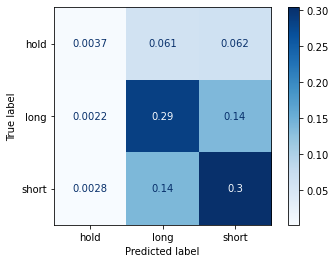

ZScorePredictor
Accuracy:  0.5930666666666666
Error Score: 6.6084


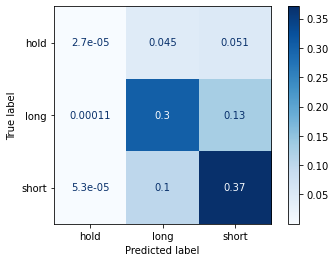

FiveDayPredictor
Accuracy:  0.67456
Error Score: 9.181866666666666


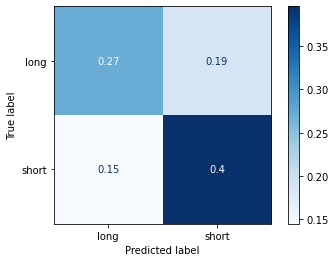

TmmrwUpPredictor
Accuracy:  0.66776
Error Score: 7.435466666666667
-------------------------------------------


Final Catboost accuracy:  0.6451288888888889
Final Catboost score:  7.7419111111111105
Final Feature Importance:                     importance
featureName                   
DPRIMElastChangeP     0.000000
CONSUMERValue         0.000000
Oceania               0.000000
UNRATEValue           0.075589
TCUValue              0.131220
...                        ...
DEXUSUKlastChangeP    7.070327
aroon                 9.655599
industry              9.679861
typPrice              9.743913
ticker               10.073438

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['CONSUMERValue', 'DPRIMElastChangeP', 'Oceania']
-------------------------------------------


Communication-Services
droppedColumns: []
valuesToTry: []
droppedColumns: ['BUSLOANSValue']
valuesToTry: ['DPRIMElastChangeP', 'PCEC96Value']
change in score by removing BUSLOANSValue is 0.04226666666666645
droppedCo

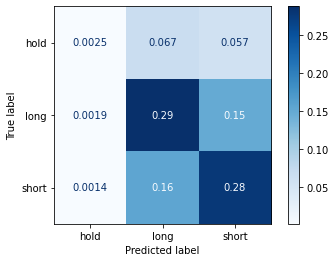

ZScorePredictor
Accuracy:  0.5676533333333333
Error Score: 5.6513333333333335


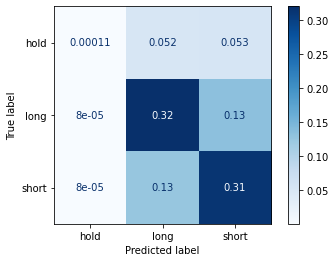

FiveDayPredictor
Accuracy:  0.6349866666666667
Error Score: 7.8748


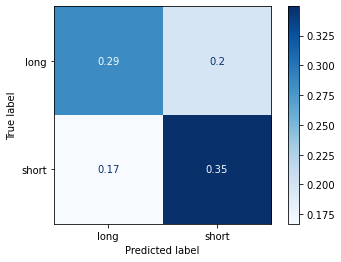

TmmrwUpPredictor
Accuracy:  0.63472
Error Score: 6.223866666666667
-------------------------------------------


Final Catboost accuracy:  0.6124533333333334
Final Catboost score:  6.583333333333333
Final Feature Importance:                               importance
featureName                             
Asia (ex China)                 0.000000
South America                   0.000000
SFTPINDM114SFRBSFlastChangeP    0.000000
DPRIMElastChangeP               0.000000
DPRIMEValue                     0.000000
...                                  ...
DGS2lastChangeP                 4.602434
typPrice                        4.966229
highVsLowPerc                   6.256083
ticker                          9.839296
aroon                          12.810999

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['Asia (ex China)', 'DPRIMEValue', 'DPRIMElastChangeP', 'PRS85006092Value', 'SFTPINDM114SFRBSFlastChangeP', 'South America']
-------------------------------------------


Consumer-Cyc

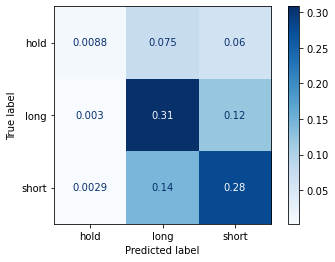

ZScorePredictor
Accuracy:  0.59288
Error Score: 6.701333333333333


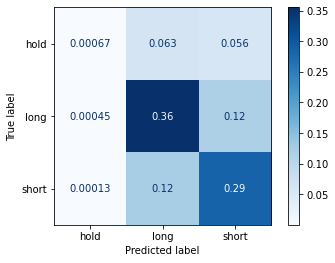

FiveDayPredictor
Accuracy:  0.6414933333333334
Error Score: 8.3352


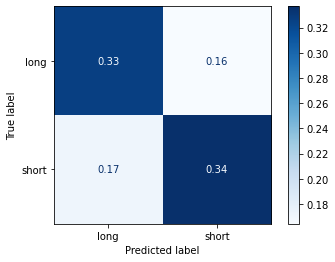

TmmrwUpPredictor
Accuracy:  0.6636266666666667
Error Score: 7.405866666666666
-------------------------------------------


Final Catboost accuracy:  0.6326666666666667
Final Catboost score:  7.4807999999999995
Final Feature Importance:                              importance
featureName                            
PRS85006092bPercent            0.000000
PCEC96Value                    0.000000
North America                  0.000000
DPRIMElastChangeP              0.000000
DPRIMEValue                    0.000000
...                                 ...
thisDayPercentChangeStdev      6.538939
typPrice                       6.701888
GOLDAMGBD228NLBMlastChangeP    6.880542
ticker                         9.497073
aroon                         12.311095

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['DPRIMEValue', 'DPRIMElastChangeP', 'North America', 'PCEC96Value', 'PRS85006092bPercent']
-------------------------------------------


Consumer-Defensive
droppedColumns: []
valuesTo

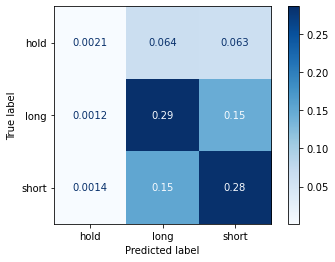

ZScorePredictor
Accuracy:  0.5716533333333333
Error Score: 5.8736


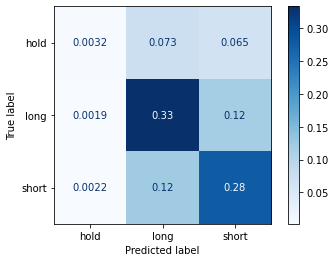

FiveDayPredictor
Accuracy:  0.6143733333333333
Error Score: 7.613066666666667


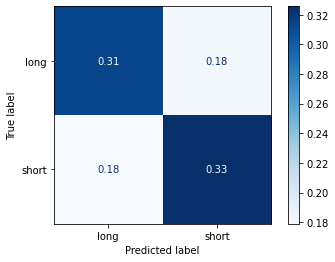

TmmrwUpPredictor
Accuracy:  0.6392533333333333
Error Score: 6.465066666666667
-------------------------------------------


Final Catboost accuracy:  0.6084266666666668
Final Catboost score:  6.6505777777777775
Final Feature Importance:                                  importance
featureName                                
Oceania                            0.000000
WPU0911Value                       0.000000
PRS85006092fiveVsTenTickAverage    0.000000
PCEC96Value                        0.000000
DPRIMElastChangeP                  0.012547
...                                     ...
NASDAQ100fiveVsTenTickAverage      7.399506
ticker                             8.763140
highVsLowPerc                      9.336292
typPrice                           9.991899
aroon                             12.558589

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['Oceania', 'PCEC96Value', 'PRS85006092fiveVsTenTickAverage', 'WPU0911Value']
-------------------------------------------


Energy
d

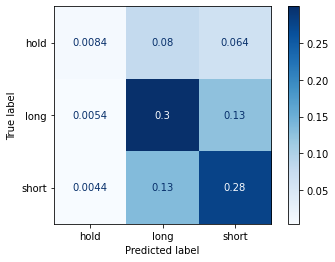

ZScorePredictor
Accuracy:  0.5858133333333333
Error Score: 6.613733333333333


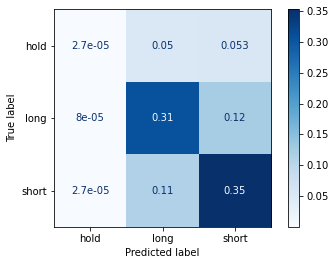

FiveDayPredictor
Accuracy:  0.66144
Error Score: 8.840933333333334


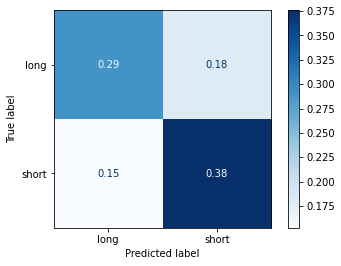

TmmrwUpPredictor
Accuracy:  0.66704
Error Score: 7.4452
-------------------------------------------


Final Catboost accuracy:  0.6380977777777778
Final Catboost score:  7.633288888888889
Final Feature Importance:                        importance
featureName                      
Misery Index             0.000000
PCEC96Value              0.000000
DPRIMElastChangeP        0.000000
DPRIMEValue              0.000000
CONSUMERValue            0.020272
...                           ...
DEXJPUSlastChangeP       6.394021
DTWEXAFEGSlastChangeP    7.777361
DEXUSUKlastChangeP       8.093473
ticker                   8.956153
aroon                   10.252983

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['DPRIMEValue', 'DPRIMElastChangeP', 'Misery Index', 'PCEC96Value']
-------------------------------------------


Financial-Services
droppedColumns: []
valuesToTry: []
droppedColumns: ['CASS-CTLI-Index']
valuesToTry: ['CONSUMERValue', 'CONSUMERbPercent', 'CONSUMERfiveVsTenTickAverage'

change in score by removing South America is -0.0904888888888884
droppedColumns: ['CASS-CTLI-Index', 'CONSUMERbPercent', 'CONSUMERfiveVsTenTickAverage', 'CPIAUCSLfiveVsTenTickAverage', 'DPRIMElastChangeP', 'PRS85006092fiveVsTenTickAverage', 'SFTPINDM114SFRBSFValue', 'UNRATEfiveVsTenTickAverage']
valuesToTry: ['WPU0911bPercent', 'WPU0911fiveVsTenTickAverage', 'West Europe']
change in score by removing UNRATEfiveVsTenTickAverage is 0.05782222222222266
droppedColumns: ['CASS-CTLI-Index', 'CONSUMERbPercent', 'CONSUMERfiveVsTenTickAverage', 'CPIAUCSLfiveVsTenTickAverage', 'DPRIMElastChangeP', 'PRS85006092fiveVsTenTickAverage', 'SFTPINDM114SFRBSFValue', 'UNRATEfiveVsTenTickAverage', 'WPU0911bPercent']
valuesToTry: ['WPU0911fiveVsTenTickAverage', 'West Europe']
change in score by removing WPU0911bPercent is -0.01968888888888909
droppedColumns: ['CASS-CTLI-Index', 'CONSUMERbPercent', 'CONSUMERfiveVsTenTickAverage', 'CPIAUCSLfiveVsTenTickAverage', 'DPRIMElastChangeP', 'PRS85006092fiveVsTenTickA

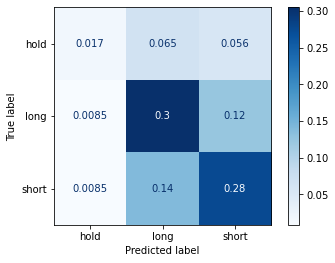

ZScorePredictor
Accuracy:  0.59712
Error Score: 6.685466666666667


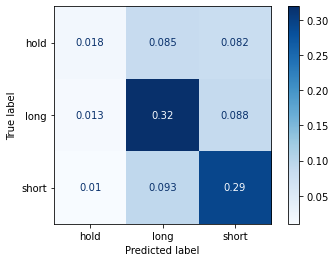

FiveDayPredictor
Accuracy:  0.6287733333333333
Error Score: 8.619333333333334


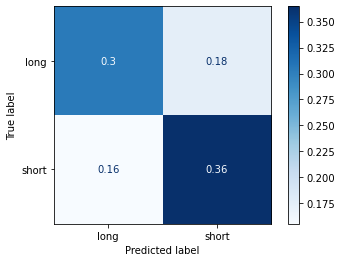

TmmrwUpPredictor
Accuracy:  0.6696266666666667
Error Score: 7.561733333333334
-------------------------------------------


Final Catboost accuracy:  0.63184
Final Catboost score:  7.622177777777778
Final Feature Importance:                               importance
featureName                             
PCEC96Value                     0.000000
CPIAUCSLfiveVsTenTickAverage    0.000000
WPU0911bPercent                 0.000000
Inflation Rate                  0.000000
CASS-CTLI-Index                 0.000000
...                                  ...
NASDAQCOMbPercent               6.932699
aroon                          12.071395
slowVSFastKAMA                 13.375417
industry                       16.309012
ticker                         19.518592

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['BUSLOANSbPercent', 'BUSLOANSfiveVsTenTickAverage', 'CASS-CTLI-Index', 'CPIAUCSLfiveVsTenTickAverage', 'DPRIMEValue', 'DPRIMElastChangeP', 'Inflation Rate', 'North America', 'PCEC96V

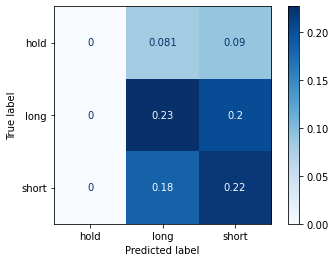

ZScorePredictor
Accuracy:  0.4450704225352113
Error Score: 1.7267605633802816


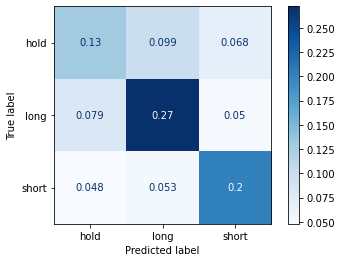

FiveDayPredictor
Accuracy:  0.6028169014084507
Error Score: 7.185915492957746


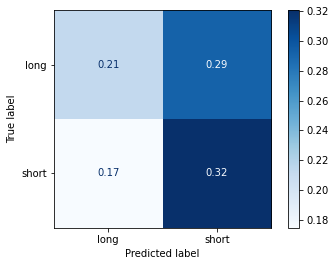

TmmrwUpPredictor
Accuracy:  0.5329577464788733
Error Score: 2.191549295774648
-------------------------------------------


Final Catboost accuracy:  0.5269483568075117
Final Catboost score:  3.7014084507042253
Final Feature Importance:                            importance
featureName                          
ticker                       0.000000
CASS-CTLI-Index              0.000000
DPRIMElastChangeP            0.005004
CCLACBW027SBOGValue          0.016147
SP500lastChangeP             0.055620
...                               ...
thisDayPercentChangeStdev    5.988873
slowVSFastKAMA               6.391388
highVsLowPerc                7.216972
typPrice                     8.670920
aroon                        8.883870

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['CASS-CTLI-Index', 'ticker']
-------------------------------------------


Healthcare
droppedColumns: []
valuesToTry: []
droppedColumns: ['BUSLOANSValue']
valuesToTry: ['DPRIMEValue', 'DPRIMElastChangeP', 'PCE

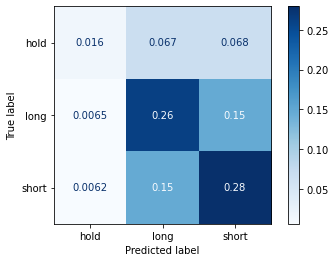

ZScorePredictor
Accuracy:  0.5573333333333333
Error Score: 5.3348


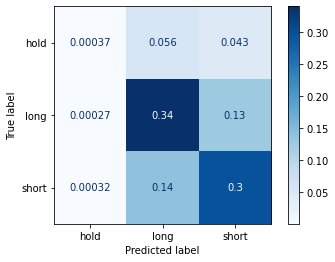

FiveDayPredictor
Accuracy:  0.6351733333333334
Error Score: 7.802133333333333


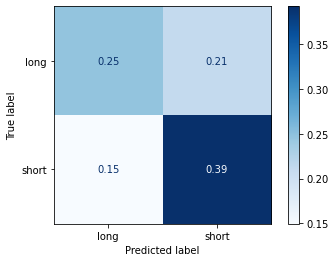

TmmrwUpPredictor
Accuracy:  0.6390133333333333
Error Score: 6.308133333333333
-------------------------------------------


Final Catboost accuracy:  0.6105066666666666
Final Catboost score:  6.481688888888889
Final Feature Importance:                                  importance
featureName                                
UNRATEfiveVsTenTickAverage         0.000000
DPRIMElastChangeP                  0.000000
DPRIMEValue                        0.000000
PRS85006092fiveVsTenTickAverage    0.000000
BUSLOANSbPercent                   0.000000
...                                     ...
thisDayPercentChangeStdev          6.416365
typPrice                           7.694102
highVsLowPerc                     10.551529
aroon                             15.634778
ticker                            21.526187

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['BUSLOANSbPercent', 'DPRIMEValue', 'DPRIMElastChangeP', 'PRS85006092bPercent', 'PRS85006092fiveVsTenTickAverage', 'PRS85006092lastCh

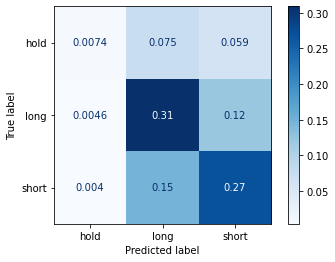

ZScorePredictor
Accuracy:  0.5857066666666667
Error Score: 6.506


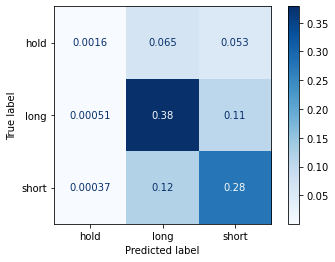

FiveDayPredictor
Accuracy:  0.6553333333333333
Error Score: 8.8392


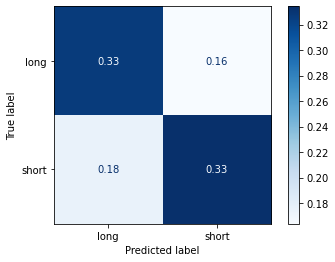

TmmrwUpPredictor
Accuracy:  0.6610666666666667
Error Score: 7.318666666666667
-------------------------------------------


Final Catboost accuracy:  0.6340355555555556
Final Catboost score:  7.554622222222222
Final Feature Importance:                              importance
featureName                            
Asia (ex China)                0.000000
CONSUMERlastChangeP            0.000000
DPRIMEValue                    0.000000
DPRIMElastChangeP              0.000000
Expenditures Index             0.000000
...                                 ...
thisDayPercentChangeStdev      8.219346
typPrice                       8.228310
aroon                         10.882643
DEXUSUKfiveVsTenTickAverage   11.243197
ticker                        12.405232

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['Asia (ex China)', 'BUSLOANSValue', 'BUSLOANSbPercent', 'CONSUMERlastChangeP', 'CPIAUCSLfiveVsTenTickAverage', 'DPRIMEValue', 'DPRIMElastChangeP', 'Expenditures Index', 'PCEC96Value', 

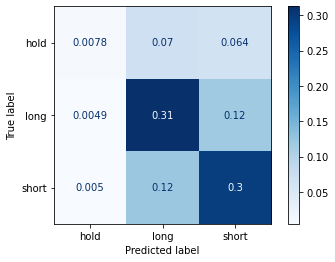

ZScorePredictor
Accuracy:  0.61688
Error Score: 7.640666666666666


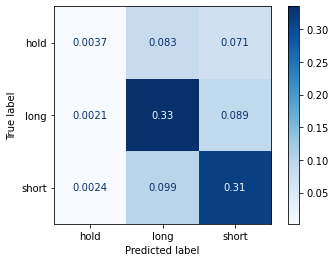

FiveDayPredictor
Accuracy:  0.6524266666666667
Error Score: 9.277466666666667


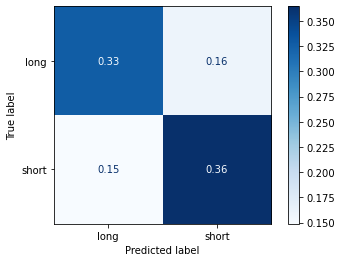

TmmrwUpPredictor
Accuracy:  0.6916
Error Score: 8.408266666666666
-------------------------------------------


Final Catboost accuracy:  0.6536355555555555
Final Catboost score:  8.442133333333333
Final Feature Importance:                     importance
featureName                   
DPRIMEValue           0.000000
DPRIMElastChangeP     0.000000
PCEC96Value           0.000000
CASS-CTLI-Index       0.000000
North America         0.037200
...                        ...
DGS2lastChangeP       5.425004
industry              5.891726
ticker                6.993075
DEXCHUSlastChangeP    7.122740
aroon                 8.107777

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['CASS-CTLI-Index', 'DPRIMEValue', 'DPRIMElastChangeP', 'PCEC96Value']
-------------------------------------------


Technology
droppedColumns: []
valuesToTry: []
droppedColumns: ['BUSLOANSbPercent']
valuesToTry: ['CASS-CTLI-Index', 'CPIAUCSLValue', 'CPIAUCSLfiveVsTenTickAverage', 'China (Estimated)', 'DPRIMEValu

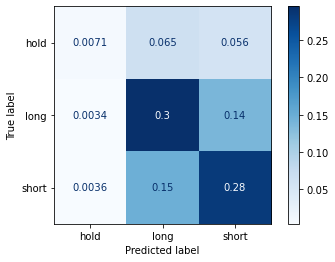

ZScorePredictor
Accuracy:  0.58608
Error Score: 6.269733333333333


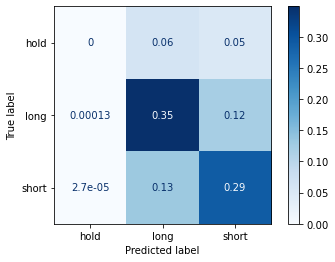

FiveDayPredictor
Accuracy:  0.63792
Error Score: 8.0876


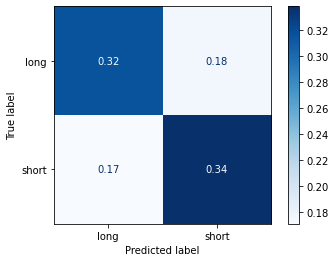

TmmrwUpPredictor
Accuracy:  0.65312
Error Score: 6.979733333333333
-------------------------------------------


Final Catboost accuracy:  0.6257066666666667
Final Catboost score:  7.112355555555555
Final Feature Importance:                                  importance
featureName                                
PRS85006092lastChangeP             0.000000
PRS85006092fiveVsTenTickAverage    0.000000
UNRATEValue                        0.000000
WPU0911fiveVsTenTickAverage        0.000000
DPRIMEValue                        0.000000
...                                     ...
GOLDAMGBD228NLBMlastChangeP        8.481979
thisDayPercentChangeStdev          8.817430
typPrice                           9.948969
ticker                            11.113076
aroon                             13.305968

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['BUSLOANSValue', 'DPRIMEValue', 'DPRIMElastChangeP', 'PRS85006092fiveVsTenTickAverage', 'PRS85006092lastChangeP', 'UNRATEValue', 'WPU0911fiveVs

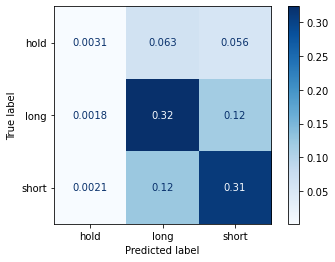

ZScorePredictor
Accuracy:  0.6370933333333333
Error Score: 8.172


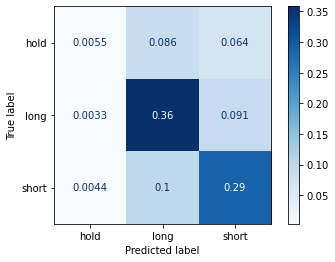

FiveDayPredictor
Accuracy:  0.6514933333333334
Error Score: 9.1716


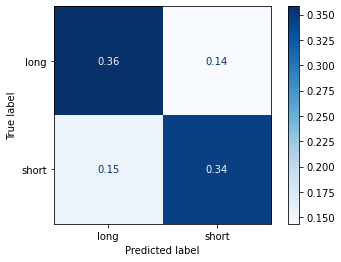

TmmrwUpPredictor
Accuracy:  0.7026933333333333
Error Score: 8.8768
-------------------------------------------


Final Catboost accuracy:  0.66376
Final Catboost score:  8.740133333333334
Final Feature Importance:                            importance
featureName                          
CPIAUCSLbPercent             0.000000
CPIAUCSLValue                0.036656
CONSUMERValue                0.095862
M1Value                      0.114258
East & Central Europe        0.133429
...                               ...
DEXJPUSlastChangeP           4.490353
DGS30fiveVsTenTickAverage    5.307530
ticker                       6.391690
aroon                        8.911072
typPrice                    12.222692

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['CPIAUCSLbPercent']
-------------------------------------------




In [5]:
for file in os.listdir(sectorFolder):
    sector = file.split('.')[0]
    sector = sector.replace(' ', '-')
    print(sector)
    droppedColumns = []
    valuesToTry = []
    seenCol = []
    lastScore = 0
    lastAccuracy = 0
    toContinue = True
    newToRemove = None
    first = True
    oldScore = None
    while (toContinue):
        print('droppedColumns: {}'.format(droppedColumns))
        print('valuesToTry: {}'.format(valuesToTry))
        toRemove, newScore, colCount, _ = buildForest(file, droppedColumns, False)
        for x in toRemove:
            seenCol.append(x)
        if not first:
            print('change in score by removing {} is {}'.format(droppedColumns[-1], newScore - oldScore))
            if newScore <= oldScore :
                droppedColumns.pop()
                if len(valuesToTry) == 0:
                    toContinue  = False
                else:
                    droppedColumns.append(valuesToTry.pop(0))
            else:
                for x in toRemove:
                    if x not in seenCol:
                        valuesToTry.append(x)
                if len(valuesToTry) != 0:
                    droppedColumns.append(valuesToTry.pop(0))
                else:
                    toContinue = False
        else : #if first
            first = False
            valuesToTry = toRemove
            droppedColumns.append(valuesToTry.pop(0))
        oldScore = newScore
    print('Final dropped columns:', droppedColumns)
    verbose = True
    buildForest(file, droppedColumns, True)     
    verbose = False
    print('-------------------------------------------\n\n')

